In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
import torchvision.transforms as tf
from tqdm import tqdm
from predict import *
# from HIST2ST_Baseline import *
from HGGEP_HGNN import *
from dataset import ViT_HER2ST, ViT_SKIN
from scipy.stats import pearsonr,spearmanr
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from copy import deepcopy as dcp
from collections import defaultdict as dfd
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

/home/zy/anaconda3/envs/gtn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zy/anaconda3/envs/gtn/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[easydl] tensorflow not available!


# Data Loading

In [2]:
name=[*[f'A{i}' for i in range(2,7)],*[f'B{i}' for i in range(1,7)],
      *[f'C{i}' for i in range(1,7)],*[f'D{i}' for i in range(1,7)],
      *[f'E{i}' for i in range(1,4)],*[f'F{i}' for i in range(1,4)],*[f'G{i}' for i in range(1,4)]]
patients = ['P2', 'P5', 'P9', 'P10']
reps = ['rep1', 'rep2', 'rep3']
skinname = []
for i in patients:
    for j in reps:
        skinname.append(i+'_ST_'+j)
device='cuda'
tag='5-7-2-8-4-16-32'
k,p,d1,d2,d3,h,c=map(lambda x:int(x),tag.split('-'))
dropout=0.2
random.seed(12000)
np.random.seed(12000)
torch.manual_seed(12000)
torch.cuda.manual_seed(12000)
torch.cuda.manual_seed_all(12000)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


# Hist2ST Prediction

### To run the trained model, please select the trained model and replace the value of the variable fold with the number in the name of the selected trained model.

Test one!

In [4]:
fold=12
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785

testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
label=testset.label[testset.names[0]]
genes=785
model=HGGEP(
    depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
    kernel_size=k, patch_size=p,
    heads=h, channel=c, dropout=0.2,
    zinb=0.25, nb=False,
    bake=5, lamb=0.5, 
)

te_names: ['C2']
Loading imgs...
Loading metadata...


In [ ]:
# Test all

folds=[]
for i in range(32):
    folds.append(i)
print(folds)
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785

R_HGGEP = []

for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    label=testset.label[testset.names[0]]
    # genes=785
    model=HGGEP(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=0, lamb=0.5,
    )
    model.load_state_dict(torch.load(f'./model/her2st/'+str(fold)+'-HGGEP.ckpt'))
    pred, gt = test(model, test_loader,'cuda')
    R=get_R(pred,gt)[0]
    R_HGGEP.append(R)
    print('Pearson Correlation Median:',np.nanmedian(R))

In [21]:
# add mean and median

import numpy as np

# print(len(R_HGGEP))
# print(len(R_Hist2ST))

# # add mean and median
# mean_HGGEP = np.mean(R_STNet, axis=0)
# # mean_Hist2ST = np.mean(R_Hist2ST, axis=0)

# median_HGGEP = np.median(R_STNet, axis=0)
# # median_Hist2ST = np.median(R_Hist2ST, axis=0)

# # # 添加中位数到原始数组的末尾
# R_HGGEP_with_mean_median = np.vstack([R_STNet, mean_HGGEP, median_HGGEP])
# # R_Hist2ST_with_mean_median = np.vstack([R_Hist2ST, mean_Hist2ST, median_Hist2ST])


# # print(R_HGGEP_with_mean_median.shape)  # 应该是 (34, 785)
# # print(R_Hist2ST_with_mean_median.shape)  # 应该是 (34, 785)
# # # 打印结果
# print(R_HGGEP_with_mean_median.shape, R_HGGEP_with_mean_median[-1][:10]) 


# # # 假设 data 是你的二维数组 [32, 785]
# np.save('./Output/STNet_her2.npy', R_HGGEP_with_mean_median)
# np.save('Hist2ST_output.npy', R_Hist2ST_with_mean_median)

R_HGGEP_with_mean_median = np.load('./Output/HGGEP_her2.npy')
R_Hist2ST_with_mean_median = np.load('./Output/Hist2ST_her2.npy')
R_HisToGene_with_mean_median = np.load('./Output/HisToGene_her2.npy')
R_STNet_with_mean_median = np.load('./Output/STNet_her2.npy')


In [8]:
# 取最后mean和median的均值和中间值

print(R_HGGEP_with_mean_median.shape)  # 应该是 (34, 785)
print(R_Hist2ST_with_mean_median.shape)  # 应该是 (34, 785)
print(R_HisToGene_with_mean_median.shape)  # 应该是 (34, 785)
print(R_HisToGene_with_mean_median.shape)  # 应该是 (34, 785)

# Extract the last subarrays
last_subarray_HGGEP = R_HGGEP_with_mean_median[-2, :]
last_subarray_Hist2ST = R_Hist2ST_with_mean_median[-2, :]
# Convert to Pandas DataFrame
df_last_HGGEP = pd.DataFrame(last_subarray_HGGEP)
df_last_Hist2ST = pd.DataFrame(last_subarray_Hist2ST)

# Calculate mean and median using Pandas DataFrame methods
mean_HGGEP = df_last_HGGEP.mean().values
mean_Hist2ST = df_last_Hist2ST.mean().values

median_HGGEP = np.median(R_HGGEP_with_mean_median[:, -1])
median_Hist2ST = np.median(R_Hist2ST_with_mean_median[:, -1])


# Print the results
print("Mean HGGEP:", mean_HGGEP)
print("Mean Hist2ST:", mean_Hist2ST)
print("Median HGGEP:", median_HGGEP)
print("Median Hist2ST:", median_Hist2ST)

(34, 785)
(34, 785)
(34, 785)
(34, 785)
Mean HGGEP: [0.19456845]
Mean Hist2ST: [0.15636345]
Median HGGEP: 0.11109329471896254
Median Hist2ST: 0.0950236368053993


# Figure 2, comprasion of different models

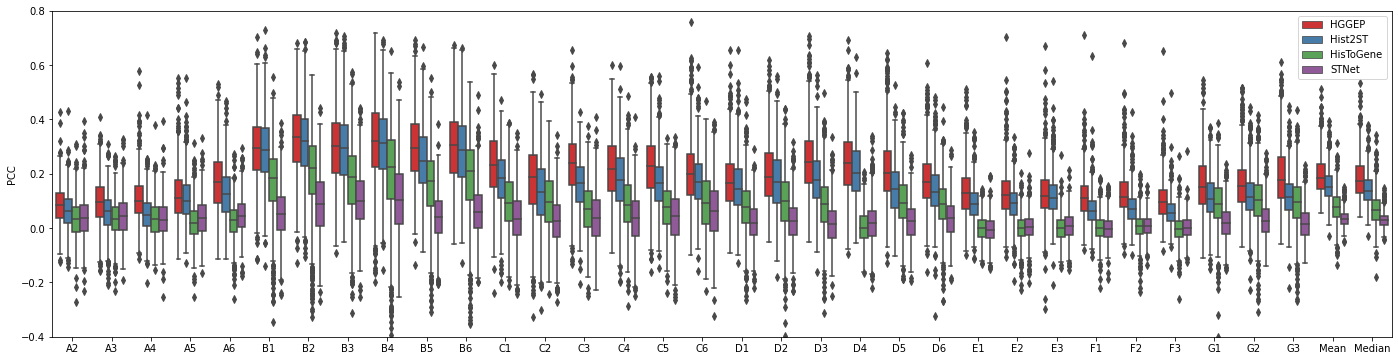

In [22]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

R_HGGEP_with_mean_median = np.load('./Output/HGGEP_her2.npy')
R_Hist2ST_with_mean_median = np.load('./Output/Hist2ST_her2.npy')
R_HisToGene_with_mean_median = np.load('./Output/HisToGene_her2.npy')
R_STNet_with_mean_median = np.load('./Output/STNet_her2.npy')


x_label = ['A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'C1', 'C2', 'C3', \
           'C4', 'C5', 'C6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'E1', 'E2', 'E3', 'F1', 'F2', 'F3', 'G1', 'G2', 'G3', 'Mean', 'Median']

df_combined = pd.DataFrame()
# 重复操作32次
for i in range(34):
    # 创建 DataFrame，添加分类变量和列名
    df_class_i = pd.DataFrame(np.transpose(np.array([R_HGGEP_with_mean_median[i], R_Hist2ST_with_mean_median[i],\
                                                      R_HisToGene_with_mean_median[i], R_STNet_with_mean_median[i]])),\
                                                      columns=['HGGEP', 'Hist2ST', 'HisToGene', 'STNet'])
    # df_class_i = pd.DataFrame(data_class1, columns=['HGGEP', 'Hist2ST', 'HisToGene'])
    df_class_i['Category'] = x_label[i]  # 使用 f-string 添加不同的后缀数字

    # 将当前 DataFrame 追加到结果 DataFrame
    df_combined = df_combined._append(df_class_i, ignore_index=True)

# 将列名融入数据，以便使用`hue`
df_combined_melted = pd.melt(df_combined, id_vars=['Category'], var_name='Column')

# 设置图形大小
plt.figure(figsize=(24, 6))  # width and high

# 创建箱线图
# sns.boxplot(x='Category', y='value', data=df_combined_melted, hue='Column', showfliers=True, width=0.8, palette='Set2')
boxplot = sns.boxplot(x='Category', y='value', data=df_combined_melted, hue='Column', showfliers=True, width=0.8, palette='Set1')

# 设置 y 轴上下限
plt.ylim(-0.4, 0.8)

# 设置图形背景为白色
plt.gcf().set_facecolor('white')

# 显示图例
plt.legend(title='')

# 添加标题和标签
# plt.title('Boxplots of Columns by Category')
plt.xlabel('')
plt.ylabel('PCC')

# 显示图形
# plt.show()
plt.savefig('./figures/2_HER2+.pdf')
# plt.savefig('./figures/HER2+.png', dpi=600)

# Test her2st all!

In [12]:
folds=[]
from HGGEP_HGNN import *
for i in range(32):
    folds.append(i)
# print(folds)
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785
gene_names = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))

def comp_tsne_km(adata,k=10):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
    adata.obs['kmeans'] = kmeans.labels_.astype(str)
    return adata

def get_PCC(adata_pre, adata_true):
    # 提取 var_names 列的基因名称
    gene_names = adata_pre.columns

    # 初始化一个空的 DataFrame 用于存储结果
    result_df = pd.DataFrame(index=['-log10_PV', 'PCC', 'PV',], columns=gene_names)

    # 计算每一列的皮尔逊相关系数和 p-value
    for gene in gene_names:
        corr_coef, p_value = pearsonr(adata_pre[gene], adata_true[gene])
        result_df[gene] = [-np.log10(p_value), corr_coef, p_value]

    # 转置 DataFrame，使得基因名称成为索引
    result_df = result_df.T

    # 根据 PCC 指数排序
    result_df_sorted = result_df.sort_values(by='-log10_PV', ascending=False)

    return result_df_sorted

results_all = []
for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    label=testset.label[testset.names[0]]
    model=Hist2ST(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=5, lamb=0.5,
    )
    model.load_state_dict(torch.load(f'/media/zy/MyPassport/UF/her2st/'+str(fold)+'-HGGEP.ckpt'))
    # model.load_state_dict(torch.load(f'./model/Hist2ST_Best_0.3031.ckpt'))
    adata_pred, adata_truth = test(model, test_loader)

    adata_pred = comp_tsne_km(adata_pred,4)
    sc.pp.scale(adata_pred)
    sc.pp.scale(adata_truth)
    adata_pred.var_names = gene_names
    adata_truth.var_names = gene_names
    adata_true = pd.DataFrame(data=adata_truth.X, index=adata_truth.obs_names, columns=adata_truth.var_names)
    adata_pre = pd.DataFrame(data=adata_pred.X, index=adata_pred.obs_names, columns=adata_pred.var_names)
    res = get_PCC(adata_pre, adata_true)
    # print(res)
    results_all.append(res)


te_names: ['A2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

h: torch.Size([325, 1024])
x: torch.Size([325, 785])


KeyboardInterrupt: 

In [ ]:
folds=[]

# from HIST2ST import *
from HIST2ST_Baseline import *
# from HIST2ST_HGNN import *
for i in range(32):
    folds.append(i)
# print(folds)
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785
gene_names = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))

def comp_tsne_km(adata,k=10):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
    adata.obs['kmeans'] = kmeans.labels_.astype(str)
    return adata

def get_PCC(adata_pre, adata_true):
    # 提取 var_names 列的基因名称
    gene_names = adata_pre.columns

    # 初始化一个空的 DataFrame 用于存储结果
    result_df = pd.DataFrame(index=['-log10_PV', 'PCC', 'PV',], columns=gene_names)

    # 计算每一列的皮尔逊相关系数和 p-value
    for gene in gene_names:
        corr_coef, p_value = pearsonr(adata_pre[gene], adata_true[gene])
        result_df[gene] = [-np.log10(p_value), corr_coef, p_value]

    # 转置 DataFrame，使得基因名称成为索引
    result_df = result_df.T

    # 根据 PCC 指数排序
    result_df_sorted = result_df.sort_values(by='-log10_PV', ascending=False)

    return result_df_sorted

Hist2ST_results_all = []
for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    label=testset.label[testset.names[0]]
    model=Hist2ST(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=5, lamb=0.5,
    )
    # model.load_state_dict(torch.load(f'./model/her2st/'+str(fold)+'-HGGEP.ckpt'))
    model.load_state_dict(torch.load(f'./model/her2st_official/'+str(fold)+'-Hist2ST.ckpt'))
    # model.load_state_dict(torch.load(f'./model/Hist2ST_Best_0.3031.ckpt'))
    adata_pred, adata_truth = test(model, test_loader)

    adata_pred = comp_tsne_km(adata_pred,4)
    sc.pp.scale(adata_pred)
    sc.pp.scale(adata_truth)
    adata_pred.var_names = gene_names
    adata_truth.var_names = gene_names
    adata_true = pd.DataFrame(data=adata_truth.X, index=adata_truth.obs_names, columns=adata_truth.var_names)
    adata_pre = pd.DataFrame(data=adata_pred.X, index=adata_pred.obs_names, columns=adata_pred.var_names)
    res = get_PCC(adata_pre, adata_true)
    # print(res)
    Hist2ST_results_all.append(res)

# Top gene prediction

In [ ]:
# Calculate the mean across all DataFrames element-wise
mean_df = np.mean([df.values for df in results_all], axis=0)

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame(mean_df, index=results_all[0].index, columns=results_all[0].columns)

# Print the resulting DataFrame
print(mean_df[:10])

# 计算对应的基因的表达量 ： HGGEP
#          -log10_PV       PCC            PV
# GNAS     41.461921  0.623105  5.491569e-17
# UBA52    30.599432  0.565826  9.797935e-13
# MUCL1    27.730870  0.542192  1.220741e-10
# HLA-B    25.330913  0.522077  7.795413e-09
# HLA-DRA  24.376753  0.513529  1.439333e-08
# SRSF5    22.948412  0.500819  3.473500e-08
# VIM      21.857428  0.491059  9.101760e-08
# CXXC5    21.167107  0.483817  9.344792e-08
# SPARC    20.375119  0.475803  9.928255e-08
# FASN     19.608907  0.467966  1.183600e-07

In [ ]:
# 计算对应的基因的表达量 ： Hist2ST
# Calculate the mean across all DataFrames element-wise
mean_df = np.mean([df.values for df in Hist2ST_results_all], axis=0)

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame(mean_df, index=Hist2ST_results_all[0].index, columns=Hist2ST_results_all[0].columns)
print(mean_df[:10])
# Print the resulting DataFrame
for gene in ['GNAS', 'UBA52', 'MUCL1', 'HLA-B', 'HLA-DRA', 'SRSF5', 'VIM', 'CXXC5', 'SPARC', 'FASN']:
    print(mean_df.loc[gene])

#           -log10_PV       PCC            PV
# IGKC      27.371680  0.528938  1.432967e-10
# C3        20.338023  0.468656  6.180550e-08
# GNAS      18.061492  0.444435  7.871247e-08
# KRT17     17.083069  0.433135  3.483668e-07
# IGLC2     16.144405  0.422656  4.038377e-07
# IGLC3     15.592970  0.415894  5.110269e-07
# TMEM184A  14.760000  0.404774  1.010671e-06
# TFF3      14.316007  0.398951  1.253905e-06
# SCD       13.835811  0.392418  2.050736e-06
# MYL12B    13.382646  0.385515  3.082886e-06

In [ ]:
# HisToGene
#          -log10_PV       PCC        PV
# GNAS     13.793088  0.323096  0.000024
# SCD      11.294036  0.283800  0.000046
# IGLC2    10.137152  0.294930  0.000093
# C3        9.618945  0.294796  0.000134
# FASN      9.240102  0.257429  0.000224
# MYL12B    8.911048  0.293260  0.000297
# APOC1     8.569591  0.230732  0.000356
# TMEM123   8.179363  0.251036  0.000419
# SRRT      7.899371  0.247817  0.000480
# IGHA1     7.708450  0.266133  0.000530


# Figure 4 Performance comparison of top 10 gene predictions at HER2+ datasets

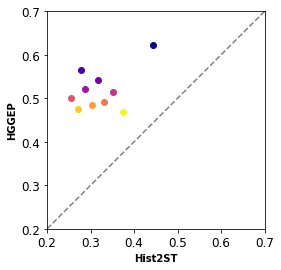

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

# 模拟数据，实际应替换为您的数据
genes = ['GNAS', 'UBA52', 'MUCL1', 'HLA-B', 'HLA-DRA', 'SRSF5', 'VIM', 'CXXC5', 'SPARC', 'FASN']
# hist2st_data = np.random.rand(10)  # 替换为Hist2ST模型的PCC数据
hist2st_data = [4.444347e-01, 0.279, 0.317, 0.287, 0.351, 0.255, 0.330, 0.304, 0.271, 0.374]
hggep_data = [ 0.6231, 0.5658, 0.5421, 0.5220, 0.5135, 0.5008, 0.49105, 0.4838, 0.4758, 0.4679]   # 替换为HGGEP模型的PCC数据

# 为每个基因生成不同的颜色
# colors = plt.cm.rainbow(np.linspace(0, 1, 10))
colors = plt.cm.plasma(np.linspace(0, 1, 10))

# 绘制散点图
for i in range(10):
    plt.scatter(hist2st_data[i], hggep_data[i], label=genes[i], color=colors[i])

# 添加标签和标题
plt.xlabel('Hist2ST', fontweight='bold')
plt.ylabel('HGGEP', fontweight='bold')
plt.title('')

# 绘制对角虚线
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', transform=plt.gca().transAxes)

# 设置坐标轴纵横比例相等
plt.gca().set_aspect('equal', adjustable='box')

# 设置图形背景为白色
plt.gcf().set_facecolor('white')

# 设置横纵轴的阈值范围为1
plt.xlim(0.2, 0.7)
plt.ylim(0.2, 0.7)

# 设置刻度线
plt.xticks(np.linspace(0.2, 0.7, 6))  # 在横轴上设置刻度线
plt.yticks(np.linspace(0.2, 0.7, 6))  # 在纵轴上设置刻度线

# 设置刻度线，并保留两位小数
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# 设置刻度值字体大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 保存高清图像
plt.savefig('./figures/4_2.pdf')

# 显示图表
plt.show()


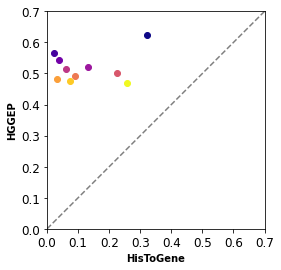

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

# 模拟数据，实际应替换为您的数据
genes = ['GNAS', 'UBA52', 'MUCL1', 'HLA-B', 'HLA-DRA', 'SRSF5', 'VIM', 'CXXC5', 'SPARC', 'FASN']

HisToGene_data = [0.323, 0.023883, 0.038710, 0.130701, 0.060204, 0.225490, 0.088668, 0.030520, 0.074998, 0.257429]
hggep_data = [0.6231, 0.5658, 0.5421, 0.5220, 0.5135, 0.5008, 0.49105, 0.4838, 0.4758, 0.4679]   # 替换为HGGEP模型的PCC数据

# 为每个基因生成不同的颜色
# colors = plt.cm.rainbow(np.linspace(0, 1, 10))
colors = plt.cm.plasma(np.linspace(0, 1, 10))

# 绘制散点图
for i in range(10):
    plt.scatter(HisToGene_data[i], hggep_data[i], label=genes[i], color=colors[i])

# 添加标签和标题
plt.xlabel('HisToGene', fontweight='bold')
plt.ylabel('HGGEP', fontweight='bold')
plt.title('')

# 绘制对角虚线
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', transform=plt.gca().transAxes)

# 设置坐标轴纵横比例相等
plt.gca().set_aspect('equal', adjustable='box')

# 设置图形背景为白色
plt.gcf().set_facecolor('white')

# 设置横纵轴的阈值范围为1
plt.xlim(0.0, 0.7)
plt.ylim(0.0, 0.7)

# 设置刻度线
plt.xticks(np.linspace(0.0, 0.7, 8))  # 在横轴上设置刻度线
plt.yticks(np.linspace(0.0, 0.7, 8))  # 在纵轴上设置刻度线

# 设置刻度线，并保留两位小数
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# 设置刻度值字体大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 保存高清图像
plt.savefig('./figures/4_1.pdf')

# 显示图表
plt.show()

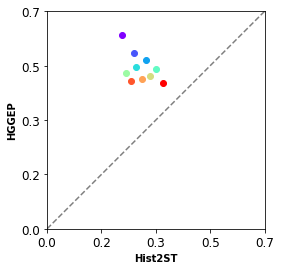

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

# 模拟数据，实际应替换为您的数据
genes = ['GNAS', 'UBA52', 'MUCL1', 'HLA-B', 'HLA-DRA', 'SRSF5', 'VIM', 'CXXC5', 'SPARC', 'FASN']

HisToGene_data = [0.323, 0.023883, 0.038710, 0.130701, 0.060204, 0.225490, 0.088668, 0.030520, 0.074998, 0.257429]
hist2st_data = [0.24, 0.279, 0.317, 0.287, 0.351, 0.255, 0.330, 0.304, 0.271, 0.374]
hggep_data = [0.6231, 0.5658, 0.5421, 0.5220, 0.5135, 0.5008, 0.49105, 0.4838, 0.4758, 0.4679]   # 替换为HGGEP模型的PCC数据

# 为每个基因生成不同的颜色
colors = plt.cm.rainbow(np.linspace(0, 1, 10))

# 绘制散点图
for i in range(10):
    # plt.scatter(HisToGene_data[i], hggep_data[i], label=genes[i], color=colors[i])
    plt.scatter(hist2st_data[i], hggep_data[i], label=genes[i], color=colors[i])

# 添加标签和标题
plt.xlabel('Hist2ST', fontweight='bold')
plt.ylabel('HGGEP', fontweight='bold')
plt.title('')

# 绘制对角虚线
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', transform=plt.gca().transAxes)

# 设置坐标轴纵横比例相等
plt.gca().set_aspect('equal', adjustable='box')

# 设置图形背景为白色
plt.gcf().set_facecolor('white')

# 设置横纵轴的阈值范围为1
plt.xlim(0.0, 0.7)
plt.ylim(0.0, 0.7)

# 设置刻度线
plt.xticks(np.linspace(0.0, 0.7, 5))  # 在横轴上设置刻度线
plt.yticks(np.linspace(0.0, 0.7, 5))  # 在纵轴上设置刻度线

# 设置刻度线，并保留两位小数
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# 设置刻度值字体大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 保存高清图像
plt.savefig('./figures/4_4.pdf')

# 显示图表
plt.show()

# Figure 5. Spatial domain detection based on predicted gene expressions. 

KeyError: 'Could not find key FASN in .var_names or .obs.columns.'

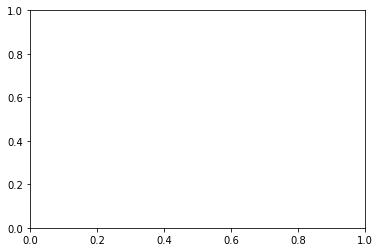

In [13]:
import matplotlib.pyplot as plt

# decide which model for generating adata_pred

img_path = '/home/zy/libo/Hist2ST/data/her2st/data/ST-imgs/B/B1/BT10737_C1_HE.jpg'
img_data = plt.imread(img_path)

sc.pl.spatial(adata_pred, img=img_data, color='FASN', spot_size=112, color_map='magma')

In [14]:
# Draw picture, show the results of gene prediction.
import matplotlib.pyplot as plt
img_path = '/home/zy/libo/Hist2ST/data/her2st/data/ST-imgs/B/B1/BT10737_C1_HE.jpg'
img_data = plt.imread(img_path)
# print(pred.shape, pred[0][:10])
sc.pl.spatial(pred, img=img_data, color='kmeans', spot_size=112)
sc.pl.spatial(gt, img=img_data, color='kmeans', spot_size=112)

sc.pl.spatial(adata_pred, img=None, color='FASN', spot_size=112, color_map='magma')

NameError: name 'pred' is not defined

# Test cscc all !

In [ ]:
from HIST2ST_HGNN_CSCC import *

folds=[]
for i in range(12):
    folds.append(i)
# print(folds)
data='cscc'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785
gene_names = list(np.load('data/skin_hvg_cut_1000.npy',allow_pickle=True))

def get_PCC(adata_pre, adata_true):
    # 提取 var_names 列的基因名称
    gene_names = adata_pre.columns

    # 初始化一个空的 DataFrame 用于存储结果
    result_df = pd.DataFrame(index=['-log10_PV', 'PCC', 'PV',], columns=gene_names)

    # 计算每一列的皮尔逊相关系数和 p-value
    for gene in gene_names:
        corr_coef, p_value = pearsonr(adata_pre[gene], adata_true[gene])
        result_df[gene] = [-np.log10(p_value), corr_coef, p_value]

    # 转置 DataFrame，使得基因名称成为索引
    result_df = result_df.T

    # 根据 PCC 指数排序
    result_df_sorted = result_df.sort_values(by='-log10_PV', ascending=False)

    return result_df_sorted

cscc_results_all = []

for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)

    model=Hist2ST(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=5, lamb=0.5,
    )

    model.load_state_dict(torch.load(f'./model/cscc/'+str(fold)+'-HGGEP.ckpt'))
    adata_pred, adata_truth = test(model, test_loader)
    adata_pred.var_names = gene_names
    adata_truth.var_names = gene_names
    adata_true = pd.DataFrame(data=adata_truth.X, index=adata_truth.obs_names, columns=adata_truth.var_names)
    adata_pre = pd.DataFrame(data=adata_pred.X, index=adata_pred.obs_names, columns=adata_pred.var_names)
    res = get_PCC(adata_pre, adata_true)
    # print(res)
    cscc_results_all.append(res)


In [15]:
# Replace df1, df2, ... with your actual DataFrames
# results_all = [df1, df2, ..., df32]

# Calculate the mean across all DataFrames element-wise
mean_df = np.mean([df.values for df in cscc_results_all], axis=0)

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame(mean_df, index=cscc_results_all[0].index, columns=cscc_results_all[0].columns)

# Print the resulting DataFrame
print(mean_df[:10])

NameError: name 'cscc_results_all' is not defined

画图，展示基因预测结果的图

In [17]:
import matplotlib.pyplot as plt
img_path = '/home/zy/libo/Hist2ST/data/her2st/data/ST-imgs/B/B1/BT10737_C1_HE.jpg'

# sc.pl.spatial(adata_pred, img=None, color='FASN', spot_size=112, color_map='magma')

img_data = plt.imread(img_path)
# print(pred.shape, pred[0][:10])
sc.pl.spatial(pred, img=img_data, color='kmeans', spot_size=112)


NameError: name 'pred' is not defined

# Fig 3: Ablation results

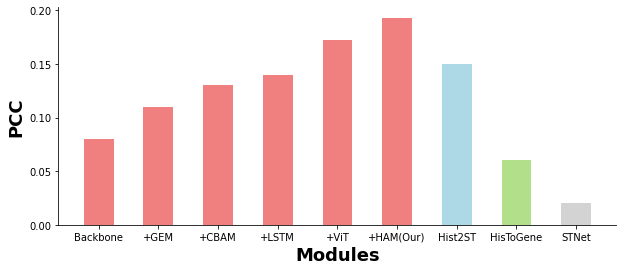

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# 模拟一些数据
modules = ['Backbone', '+GEM', '+CBAM', '+LSTM', '+ViT', '+HAM(Our)', 'Hist2ST', 'HisToGene', 'STNet']
pcc_values = [0.08, 0.11, 0.13, 0.14, 0.172, 0.193, 0.15, 0.06, 0.02]

# 使用更吸引人的颜色
colors = ['lightcoral', 'lightcoral', 'lightcoral', 'lightcoral', 'lightcoral', 'lightcoral', 'lightblue', '#b2df8a', 'lightgray']

# 调整图的大小
plt.figure(figsize=(10, 4))

# 创建柱状图，每个柱子使用不同颜色
plt.bar(modules, pcc_values, color=colors, width=0.5, label='PCC Values')

# 添加标题和标签
# plt.title('Ablation Experiment on HER2+', fontweight='bold', fontsize=20)  # 加粗标题
plt.xlabel('Modules', fontweight='bold', fontsize=18)  # 加粗 x 轴标签
plt.ylabel('PCC', fontweight='bold', fontsize=18)  # 加粗 y 轴标签

# 设置纵轴刻度标签格式
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# 设置图形背景为白色
plt.gcf().set_facecolor('white')

# 设置纵轴刻度松散点
plt.yticks([0, 0.05, 0.1, 0.15, 0.2])

# 移除上方和右方的边框
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# 保存图形为PNG文件
plt.savefig('./figures/3_HER2_Ablation.pdf')

# 显示柱状图
plt.show()


# BDS

In [57]:
gene_list = list(np.load('data/final_gene_expression.npy',allow_pickle=True))
gene_list

['KRT14',
 'KRT6A',
 'S100A8',
 'S100A9',
 'KRT16',
 'KRT6B',
 'KRT6C',
 'KRT5',
 'KRT17',
 'MT-CO2',
 'S100A2',
 'SPRR1B',
 'MT-CO1',
 'MT-CO3',
 'COL1A1',
 'ACTB',
 'PERP',
 'KRT10',
 'KRT1',
 'FABP5',
 'LGALS7B',
 'S100A7',
 'EEF1A1',
 'SFN',
 'LGALS7',
 'DCD',
 'RPLP1',
 'RPS12',
 'GJB2',
 'ACTG1',
 'B2M',
 'HLA-B',
 'RPLP2',
 'CSTA',
 'PFN1',
 'COL3A1',
 'DSP',
 'KRTDAP',
 'RPS17',
 'COL1A2',
 'TPT1',
 'RPS24',
 'SPRR2A',
 'MT-ND4',
 'RPL37A',
 'MT-ATP6',
 'CSTB',
 'RPS6',
 'RPS8',
 'RPS18',
 'TMSB10',
 'RPL13',
 'RPL13A',
 'RPL31',
 'RPL11',
 'RPLP0',
 'RPL32',
 'ENO1',
 'CALML5',
 'DSC2',
 'JUP',
 'AQP3',
 'RPS14',
 'RPS11',
 'RPL28',
 'RPL27',
 'RPS27A',
 'RPL36',
 'CXCL14',
 'MT-CYB',
 'RPS27',
 'RPS29',
 'RPL3',
 'RPL27A',
 'LDHA',
 'RPS19',
 'MT-ND3',
 'DMKN',
 'RPL9',
 'KRT2',
 'RPS28',
 'SBSN',
 'RPL8',
 'GSTP1',
 'SLPI',
 'RPL34',
 'MT-ND1',
 'RPL7A',
 'RPL6',
 'RPS2',
 'LY6D',
 'PKP1',
 'ANXA1',
 'YWHAZ',
 'RPL19',
 'RPL23',
 'ANXA2',
 'RACK1',
 'TMSB4X',
 'RPS25']

In [59]:
a = list(gene_list)
for i in a:
    print(i)

KRT14
KRT6A
S100A8
S100A9
KRT16
KRT6B
KRT6C
KRT5
KRT17
MT-CO2
S100A2
SPRR1B
MT-CO1
MT-CO3
COL1A1
ACTB
PERP
KRT10
KRT1
FABP5
LGALS7B
S100A7
EEF1A1
SFN
LGALS7
DCD
RPLP1
RPS12
GJB2
ACTG1
B2M
HLA-B
RPLP2
CSTA
PFN1
COL3A1
DSP
KRTDAP
RPS17
COL1A2
TPT1
RPS24
SPRR2A
MT-ND4
RPL37A
MT-ATP6
CSTB
RPS6
RPS8
RPS18
TMSB10
RPL13
RPL13A
RPL31
RPL11
RPLP0
RPL32
ENO1
CALML5
DSC2
JUP
AQP3
RPS14
RPS11
RPL28
RPL27
RPS27A
RPL36
CXCL14
MT-CYB
RPS27
RPS29
RPL3
RPL27A
LDHA
RPS19
MT-ND3
DMKN
RPL9
KRT2
RPS28
SBSN
RPL8
GSTP1
SLPI
RPL34
MT-ND1
RPL7A
RPL6
RPS2
LY6D
PKP1
ANXA1
YWHAZ
RPL19
RPL23
ANXA2
RACK1
TMSB4X
RPS25


: 